In [27]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from typing import Annotated, Sequence, TypedDict, Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langchain import hub
from IPython.display import  Image, display
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs = [WebBaseLoader(url) for url in urls]
docs

In [3]:
# Load documents from each WebBaseLoader
doc_list = []
for loader in docs:
    doc_list.extend(loader.load())

print(doc_list)

# Split the documents
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs_splits = text_splitter.split_documents(doc_list)
print(docs_splits)


[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n'), Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nWorkflows & agents\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n            \n            \nOur new LangChain Academy Course Deep Research with LangGraph is now live! Enroll for free.\n\n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Workflows & agents\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing searc

In [4]:
vectorstore = FAISS.from_documents(
    documents=docs_splits,
    embedding=OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever()

In [5]:
retriever.invoke("What is Langgraph?")

[Document(id='be6bd3d2-3160-4fe5-9184-0ceb64f347cb', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='What LangGraph provides\n    \n\n\n\n\n\n\n      Persistence: Human-in-the-Loop\n    \n\n\n\n\n\n      Persistence: Memory\n    \n\n\n\n\n\n      Streaming\n    \n\n\n\n\n\n      Deployment\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWorkflows and Agents¶\nThis guide reviews common patterns for agentic systems. In describing these systems, it can be useful to make a distinction between "workflows" and "agents". One way to think about this difference is nicely explained in Anthropic\'s Building Effective Agents blog post:\n\nWorkflows are systems where LLMs and tools are orchestrated through predefined code paths.\nAgents, on the other hand, are systems where LLMs dynamically direct their own processes and tool 

##### Retriever to Retriver Tools

In [6]:
retriever_tool = create_retriever_tool(
    retriever,
    'retriever_vectorstore_blod',
    "Search and run information about Langgraph."
)

## Langchain Blog-Seperate VectorStore

In [7]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]
docs = [WebBaseLoader(url).load() for url in langchain_urls]

In [8]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

docs_splits = text_splitter.split_documents(docs_list)

# Add all these text to vectorstore
vectorstoreLangChain = FAISS.from_documents(
    documents=docs_splits,
    embedding=OpenAIEmbeddings()
)

In [9]:
retrieverlangchain = vectorstoreLangChain.as_retriever()

In [10]:
retriever_tool_langchain = create_retriever_tool(
    retrieverlangchain,
    'retriever_vectorstore_Langchain_blog',
    "Search and run information about Langchain."
)

In [11]:
tools = [retriever_tool, retriever_tool_langchain]

# LangGraph Workflow

### State of The Graph

In [14]:
class AgentState(TypedDict):
    # This add_messages function defines how an update should be processed
    # Default is to replace. add_messages says 'append'
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Define Nodes

In [15]:
def agent(state: AgentState):
    """
    Invokes the agent model to gernerate a response based on the current state. Given the question, it will decide to retrieve using the retriever using the retriever tool, or simply end.
    
    Args:
        state (messages): The Current state
        
    Returns: 
        dict: The updated state with the agent response appended to messages.
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    
    # we return a list, because this will get added to the existing list
    return {
        'messages': [response]
    }

### Conditional function for the rewrite & generate decision

In [21]:
def grade_documents(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    Determines whether the retrieved documents are relevant to the question.
    
    Args: 
        state (messages): The current state
    
    Returns:
        str: A decision for whether the documents are relevent or not
    """
    
    print("---CHECK RELEVANCE---")
    
    # Data Model
    class grade(BaseModel):
        """Binary Score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
        
    
    # LLM
    model = ChatOpenAI()
    
    # LLM with tools and validation
    llm_structured_output = model.with_structured_output(grade)
    
    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a grader assessing relevance of a retrieved document to a user question. \n
            Here is the retrieved document: \n\n {context} \n\n
            Here is the user question: {question} \n
            If the document contains keyword(s) or semantic meaning related tot he user quesiton grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """,
        input_variables=['context', 'question'],
    )
    
    # Chain
    chain = prompt | llm_structured_output
    
    messages = state['messages']
    last_message = messages[-1]
    
    question = messages[0].content
    docs = last_message.content
    
    scored_result = chain.invoke({
        'question': question,
        'context': docs
    })
    
    score = scored_result.binary_score
    
    if score == 'yes':
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT")
        return "rewrite"
    

In [22]:
def generate(state: AgentState):
    """
    Generate answer
    
    Args:
        state (messages): The current state
    
    Returns:
        dict: The updated message
    """
    
    print("---GENERATE---")
    messages = state['messages']
    question = messages[0].content
    last_message = messages[-1]
    
    docs = last_message.content
    
    # prompt
    prompt = hub.pull("rlm/rag-prompt")
    
    # LLM
    llm = ChatOpenAI()
    
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    
    # Run
    response = rag_chain.invoke({
        'context': docs,
        'question': question
    })
    
    
    return {
        'messages': [response]
    }

In [23]:
def rewrite(state: AgentState):
    """
    Transform the query to produce a better question.
    
    Args: 
        state (messages): The current state
    
    Returns:
        dict: The updated state with re-phrased question
    """
    
    print("---TRANSFORM QUERY---")
    messages = state['messages']
    question = messages[0].content
    
    msg = [
        HumanMessage(
            content = f""" \n
                    Look at the input and try to reason about the underlying semantic intent/meaning. \n
                    Here is the initial question:
                    \n ---- \n
                    {question}
                    \n ---- \n
                    Formulate an improved quesiton: 
            """
        )
    ]
    
    
    # Grader
    model = ChatOpenAI()
    response = model.invoke(msg)
    
    return {
        'messages': [response]
    }

### Graph builder

In [25]:
workflow = StateGraph(AgentState)

## Add nodes to the graph
workflow.add_node('agent', agent)
workflow.add_node('retrieve', ToolNode(tools))
workflow.add_node('rewrite', rewrite)
workflow.add_node('generate', generate)

# Adding edges to the nodes
workflow.add_edge(START, 'agent')
workflow.add_conditional_edges(
    'agent',
    tools_condition,
    {
        'tools': 'retrieve',
        END: END
    }
)

# Edges taken after the 'action' node is called
workflow.add_conditional_edges(
    'retrieve',
    grade_documents
)
workflow.add_edge('rewrite', 'agent')
workflow.add_edge('generate', END)

graph = workflow.compile()

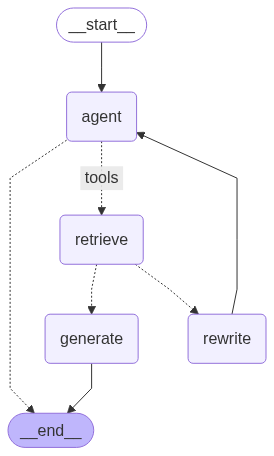

In [28]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
graph.invoke({
    'messages': "What is Langchain?"
})

---CALL AGENT---
---CHECK RELEVANCE---


e:\HashimEdisk\EndToEndProjects\AgenticAIWorkspace\langgraph_env\Lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='9093d3df-80ba-4fa7-9f13-3400152f20df'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f9A35eC8R2OsX3w663V8FZtv', 'function': {'arguments': '{"query":"Langchain"}', 'name': 'retriever_vectorstore_Langchain_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 104, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C7yfat6ePaSXRhaJm89MvnQId8Wtc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2c235d6d-71c0-4b0a-a910-6352cbaf602b-0', tool_calls=[{'name': 'retriever_vectorstore_Langchain_blog', 'args': 

In [30]:
graph.invoke({
    'messages': "What are the main components of Langgraph?"
})

---CALL AGENT---
---CHECK RELEVANCE---


e:\HashimEdisk\EndToEndProjects\AgenticAIWorkspace\langgraph_env\Lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What are the main components of Langgraph?', additional_kwargs={}, response_metadata={}, id='d96a225c-cbe5-4a7a-a671-3ab0c492f009'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sxRbHR5tq5GBcUQshtdwXZof', 'function': {'arguments': '{"query":"main components of Langgraph"}', 'name': 'retriever_vectorstore_blod'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 108, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C7yg9HRNHUO39L8Mmzuxb5gt1mr2Z', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--842ee1e5-87ac-4cf2-814f-181f3a4dede2-0', tool_calls=[{'name': 'retriever_vect

In [32]:
graph.invoke({
    'messages': "What is the Machine Learning?"
})

---CALL AGENT---
---CHECK RELEVANCE---


e:\HashimEdisk\EndToEndProjects\AgenticAIWorkspace\langgraph_env\Lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS NOT RELEVANT
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---


e:\HashimEdisk\EndToEndProjects\AgenticAIWorkspace\langgraph_env\Lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS NOT RELEVANT
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is the Machine Learning?', additional_kwargs={}, response_metadata={}, id='b8d4ee09-2635-4c11-8a11-9e482696eaab'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KtBdoL0EupMRCAxx8QKzGPoP', 'function': {'arguments': '{"query":"Machine Learning"}', 'name': 'retriever_vectorstore_blod'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 105, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C7ygiLGt1UbTY4FKbOb1ln0NdYDd8', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b9ed9580-48a2-4428-b517-bdc1564a5e49-0', tool_calls=[{'name': 'retriever_vectorstore_blod', 'args': {'